# Step 3： Modeling Evaluation
In this step we will build churn model to try to predict the churn probaility of customers, taking into account all the explanatory vaiables that we have constructed in the Step 2.<br><br>
We will also evaluate our model based on the metrics we choose and a holdout set.<br><br>
In this step, I decide to use the Extreme GBoosted method for our model. Extreme GBoosted also called $XGBoost$, is a kind of Gradient Boosting Decision Tree(GBDT) model.<br><br>
There are 5 substeps for our Modeling Evaluation:<br><br>
A. Dataset Splitting<br><br>
B. Model Developing<br><br>
C. Model Evaluation<br><br>
D. Model Finetuning<br><br>
E. Model Understanding
#### Let's start!!

In [1]:
import datetime
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import shap
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb

In [2]:
%matplotlib inline

In [3]:
sns.set(color_codes=True)

In [4]:
pd.set_option('display.max_columns', 100)

In [5]:
shap.initjs()

In [6]:
train_data = pd.read_pickle("processed_data train_data step2.pkl")
history_data = pd.read_pickle("processed_data history_data step2.pkl")

In [7]:
train = pd.merge(train_data, history_data, on="id")

In [8]:
pd.DataFrame({"Dataframe columns": train.columns})

,Dataframe columns
0,id
1,cons_12m
2,cons_gas_12m
3,cons_last_month
4,forecast_cons_12m
5,forecast_discount_energy
6,forecast_meter_rent_12m
7,forecast_price_energy_p1
8,forecast_price_energy_p2
9,forecast_price_pow_p1


## A. Data Splitting
In this part we will split the data into the variables that we are trying to predict y (churn) and those vaiables that we will use to predict churn x (the rest)

In [9]:
y = train["churn"]
X = train.drop(labels = ["id", "churn"], axis=1)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=18)

## B. Model Developing

In [11]:
model = xgb.XGBClassifier(learning_rate=0.1,use_label_encoder=False, 
                          max_depth=6, n_estimators=500, n_jobs=-1)
result = model.fit(X_train, y_train)

[22:17:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


## C. Model Evaluation

### C_1. Accuracy, Precision, Recall

In [12]:
def evaluate(model_, X_test, y_test):
    
    prediction_test = model_.predict(X_test)
    result = pd.DataFrame({"Accuracy": [metrics.accuracy_score(y_test, prediction_test)],
                          "Precision": [metrics.precision_score(y_test, prediction_test)],
                          "Recall": [metrics.recall_score(y_test, prediction_test)]})
    
    return result

In [13]:
evaluate(model, X_test, y_test)

,Accuracy,Precision,Recall
0,0.906809,0.738095,0.149398


### C_2. ROC - AUC
Lte's plot the Receiver Operating Characteristic(ROC) curve with true positive rate against the false positive rate. The AUC is the Area Under Curve, it should be $1 <= AUC <= 0.5$, the larger the AUC is, the more capable this model is for distinguish between classes.

In [14]:
def calculate_roc_auc(model, X_test, y_test):
    
    prediction_test = model.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = metrics.roc_curve(y_test, prediction_test)
    score = pd.DataFrame({"ROC-AUC": [metrics.auc(fpr, tpr)]})
    
    return fpr, tpr, score

In [15]:
def plot_roc_auc(fpr, tpr):
    
    f, ax = plt.subplots(figsize=(14,8))
    
    roc_auc = metrics.auc(fpr, tpr)
    ax.plot(fpr, tpr, lw=2, alpha=0.3, label="AUC = %0.2f" % (roc_auc))
    
    plt.plot([0,1], [0,1], linestyle='--', lw=3, color='r', label="Random", alpha=0.8)
    
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel("False Positive Rate (FPR)")
    ax.set_ylabel("True Positive Rate (TPR)")
    ax.set_title("ROC-AUC")
    ax.legend(loc="lower right")
    plt.show()

In [16]:
fpr, tpr, auc_score = calculate_roc_auc(model, X_test, y_test)

In [17]:
auc_score

,ROC-AUC
0,0.684366


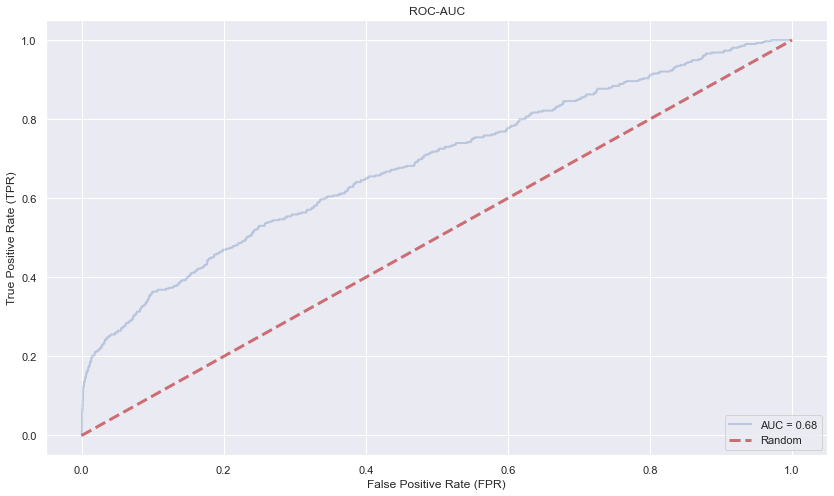

In [18]:
plot_roc_auc(fpr, tpr)
plt.show()

### Stratified K-fold Cross Validation

In [19]:
def plot_roc_curve(fprs, tprs):
    
    tprs_interp = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    f, ax = plt.subplots(figsize=(18, 10))
    
    for i, (fpr, tpr) in enumerate(zip(fprs, tprs)):
        tprs_interp.append(np.interp(mean_fpr, fpr, tpr))
        tprs_interp[-1][0] = 0.0
        roc_auc = metrics.auc(fpr, tpr)
        aucs.append(roc_auc)
        ax.plot(fpr, tpr, lw=2, alpha=0.3, label="ROC fold %d (AUC = %0.2f)" % (i, roc_auc))
    
    plt.plot([0,1], [0,1], linestyle='--', lw=3, color='r', label='Random', alpha=0.8)
    
    mean_tpr = np.mean(tprs_interp, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = metrics.auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b', 
            label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
           lw=4, alpha=0.8)
    
    std_tpr = np.std(tprs_interp, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr + std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color="grey", alpha=0.2, label=r"$\pm$ 1 std. dev.")
    
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel("False Positive Rate (FPR)")
    ax.set_ylabel("True Positive Rate (TPR)")
    ax.set_title("ROC-AUC")
    ax.legend(loc="lower right")
    plt.show()
    return (f, ax)

In [20]:
def compute_roc_auc(model, index):
    
    y_predict = model.predict_proba(X.iloc[index])[:,1]
    fpr, tpr, thresholds = metrics.roc_curve(y.iloc[index], y_predict)
    auc_score = metrics.auc(fpr, tpr)
    return fpr, tpr, auc_score

In [21]:
cv = StratifiedKFold(n_splits=5, random_state=13, shuffle=True)
fprs, tprs, scores = [],[],[]

In [22]:
for (train, test), i in zip(cv.split(X, y), range(5)):
    
    model.fit(X.iloc[train], y.iloc[train])
    _, _, auc_score_train = compute_roc_auc(model, train)
    fpr, tpr, auc_score = compute_roc_auc(model, test)
    scores.append((auc_score_train, auc_score))
    fprs.append(fpr)
    tprs.append(tpr)

[22:17:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:17:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:17:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:17:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

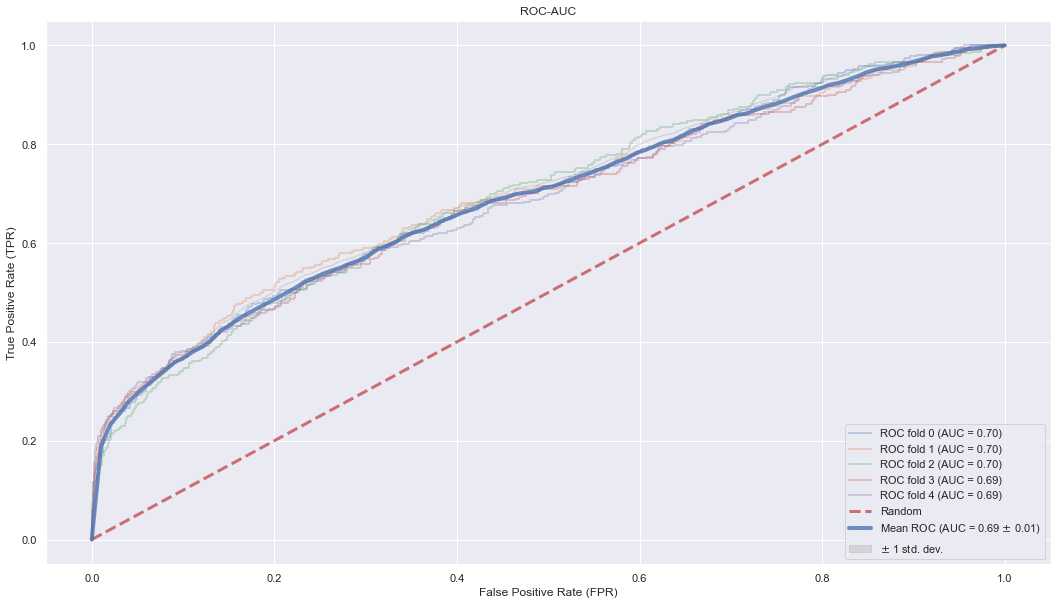

In [23]:
plot_roc_curve(fprs, tprs)
plt.show()

## D. Model Finetuning

### D_1. Random Search Cross Validation

In [24]:
from sklearn.model_selection import RandomizedSearchCV

In [25]:
params = {
    "min_child_weight": [i for i in np.arange(1,15,1)],
    "gamma": [i for i in np.arange(0,6,0.5)],
    "subsample":[i for i in np.arange(0,1.1,0.1)],
    "colsample_bytree": [i for i in np.arange(0, 1.1, 0.1)],
    "max_depth": [i for i in np.arange(1, 15, 1)],
    "scale_pos_weight": [i for i in np.arange(1, 15, 1)],
    "learning_rate": [i for i in np.arange(0, 0.15, 0.01)],
    "n_estimators": [i for i in np.arange(0, 2000, 100)]}

In [26]:
xg = xgb.XGBClassifier(objective='binary:logistic', use_label_encoder=False, silent=True, nthread=1)

In [27]:
xg_random = RandomizedSearchCV(xg, param_distributions=params,
                              n_iter=1, scoring="roc_auc",
                              n_jobs=4, cv=5, verbose=3, random_state=1001)

xg_random.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    4.2s remaining:    6.4s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    6.0s finished


[22:17:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[22:17:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100,...
                                        'min_child_weight': [1, 2, 3, 4, 5, 6,
                                                             7, 8, 9, 10, 11,
                        

In [28]:
best_random = xg_random.best_params_
best_random = {'subsample': 0.8, 'scale_pos_weight': 1, 'n_estimators': 1100,
              'min_child_weight': 1, 'max_depth': 12, 'learning_rate': 0.01, 
              'gamma': 4.0, 'colsample_bytree':0.60}

In [29]:
model_random = xgb.XGBClassifier(objective='binary:logistic',use_label_encoder=False,
                                 silent=True, nthread=1, **best_random)
fprs, tprs, scores = [],[],[]

In [30]:
for (train, test), i in zip(cv.split(X, y), range(5)):
    
    model_random.fit(X.iloc[train], y.iloc[train])
    _, _, auc_score_train = compute_roc_auc(model_random, train)
    fpr, tpr, auc_score = compute_roc_auc(model_random, test)
    scores.append((auc_score_train, auc_score))
    fprs.append(fpr)
    tprs.append(tpr)

[22:17:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[22:17:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:19:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip

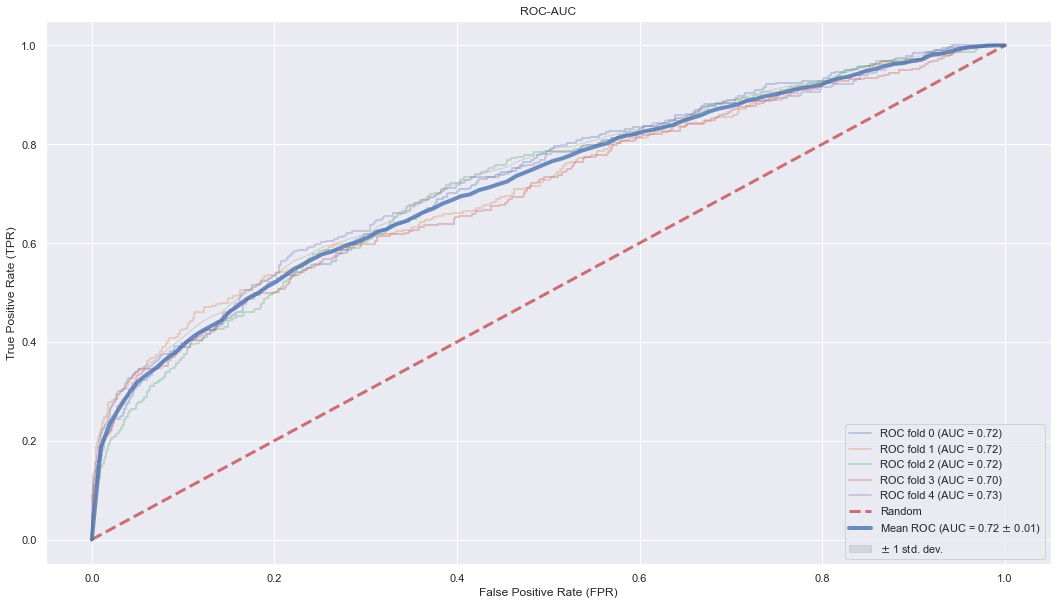

In [31]:
plot_roc_curve(fprs, tprs)
plt.show()

### D_2. Grid Search With Corss Validation

In [32]:
from sklearn.model_selection import GridSearchCV

In [33]:
param_grid = {'subsample': [0.7],
             'scale_pos_weight': [1],
             'n_estimators': [1100],
             'min_child_weight': [1],
             'max_depth': [12, 13, 14],
             'learning_rate': [0.005, 0.01],
             'gamma': [4.0],
             'colsampe_bytree':[0.6]}

In [34]:
xg = xgb.XGBClassifier(objective='binary:logistic', use_label_encoder=False, silent=True, nthread=1)

In [35]:
grid_search = GridSearchCV(estimator = xg, param_grid = param_grid, 
                           cv=5, n_jobs=-1, verbose=2, scoring = 'roc_auc')

In [36]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 13.1min finished


[22:36:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { colsampe_bytree, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[22:36:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs...
                                     scale_pos_weight=None, silent=True,
                                     subsample=None, tree_method=None,
                                     use_label_encoder=False,
                                     validate_parameters=None, verbosity=None

In [37]:
best_grid = grid_search.best_params_
best_grid

{'colsampe_bytree': 0.6,
 'gamma': 4.0,
 'learning_rate': 0.005,
 'max_depth': 13,
 'min_child_weight': 1,
 'n_estimators': 1100,
 'scale_pos_weight': 1,
 'subsample': 0.7}

In [38]:
model_grid = xgb.XGBClassifier(objective='binary:logistic',use_label_encoder=False,
                              silent=True, nthread=1, **best_grid)

In [39]:
for (train, test), i in zip(cv.split(X, y), range(5)):
    
    model_grid.fit(X.iloc[train], y.iloc[train])
    _, _, auc_score_train = compute_roc_auc(model_grid, train)
    fpr, tpr, auc_score = compute_roc_auc(model_grid, test)
    scores.append((auc_score_train, auc_score))
    fprs.append(fpr)
    tprs.append(tpr)

[22:39:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { colsampe_bytree, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[22:39:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:41:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { colsampe_bytree, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or som

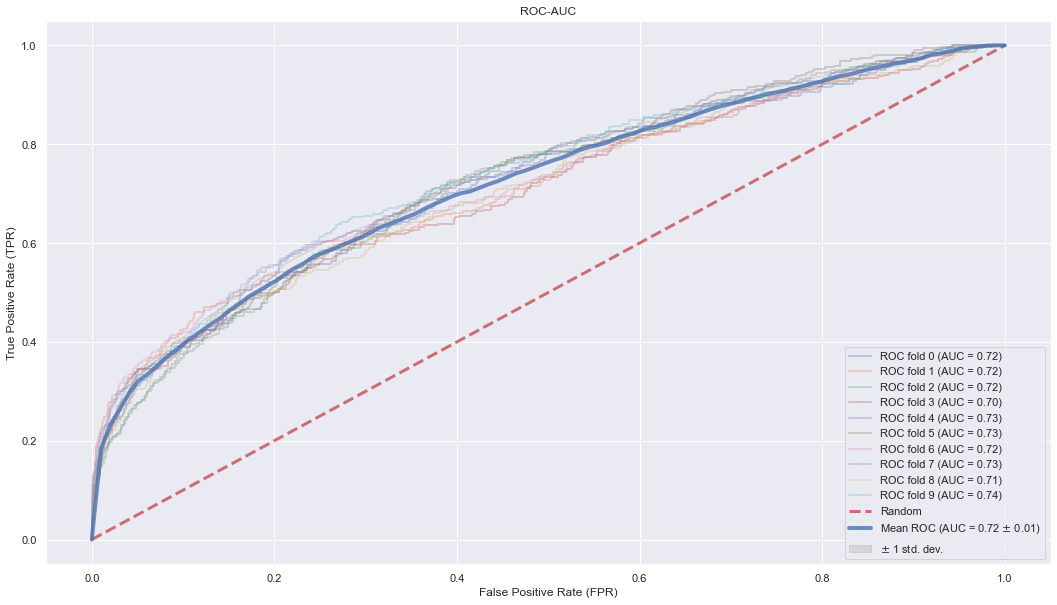

In [40]:
plot_roc_curve(fprs, tprs)
plt.show()

## E. Understanding The Model

### E_1. Feature Importance

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

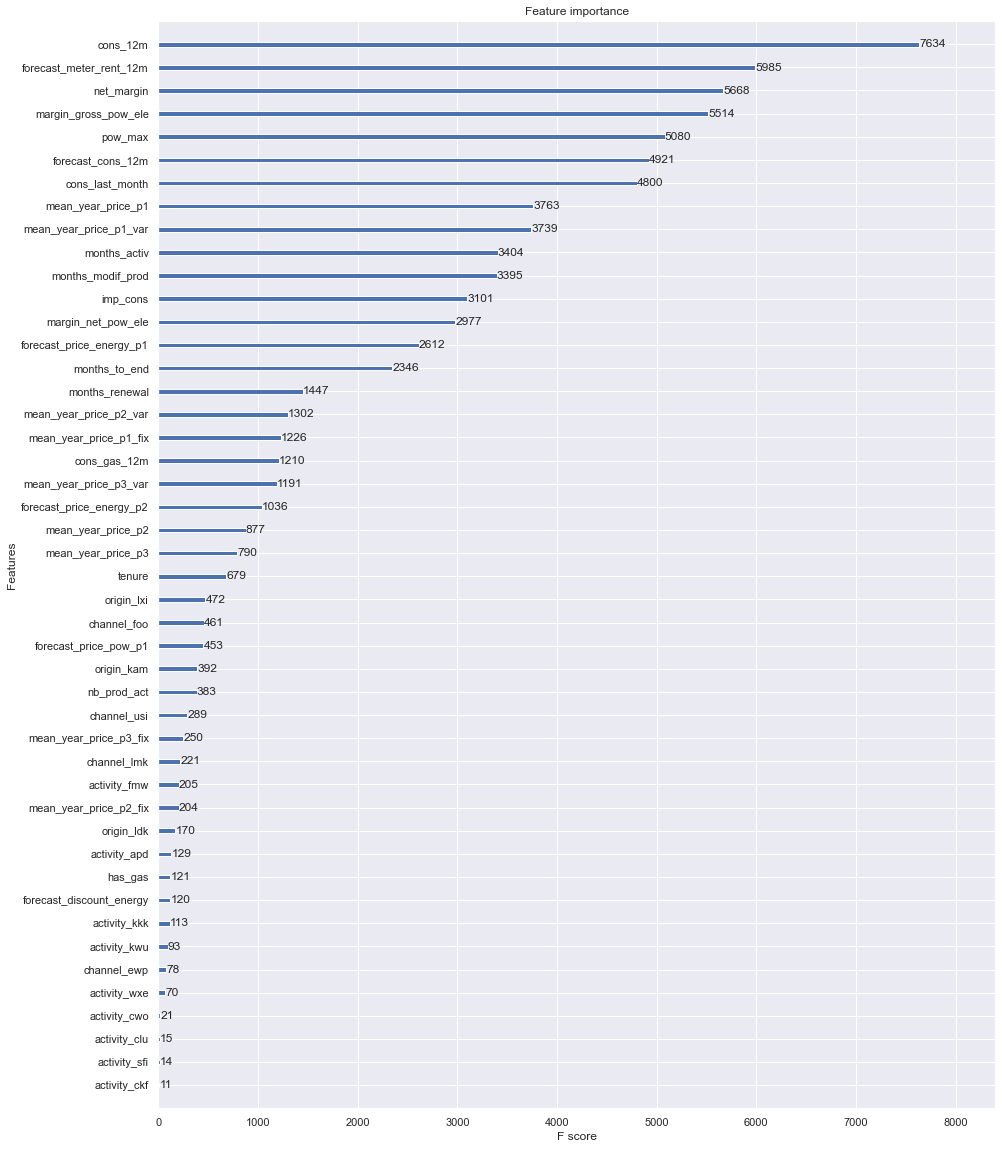

In [41]:
fig, ax = plt.subplots(figsize=(15, 20))
xgb.plot_importance(model_grid, ax=ax)

From this feature importance graph we can observe that $cons\_12m$ and $forecast\_meter\_rent\_12m$ are the features that appera the most in our model and we could infere that these two features have a significant importance in our model

### E_2. SHAP - Feature Importance

In [42]:
explainer = shap.TreeExplainer(model_grid)
shap_value = explainer.shap_values(X_test)

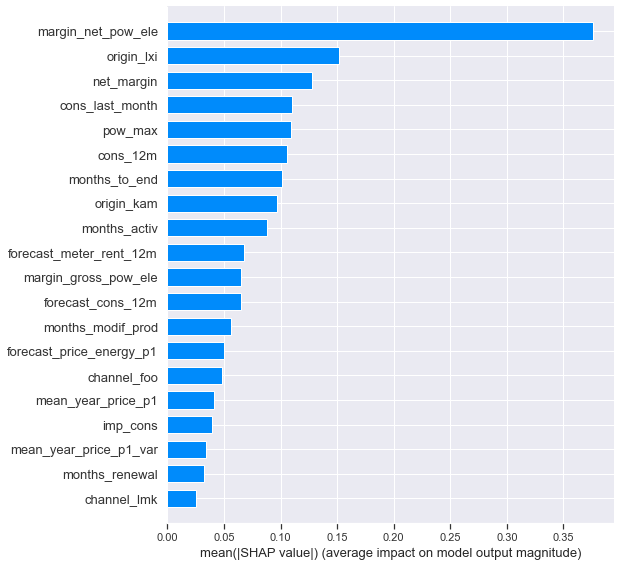

In [43]:
shap.summary_plot(shap_value, X_test, plot_type='bar')

We can see that the $margin\_net\_pow\_ele$ is the most important feature by far.

### E_3. SHAP - Partial Dependence Plot

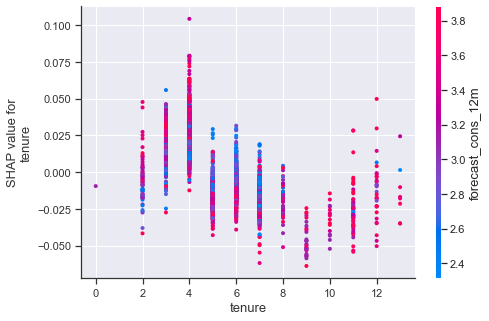

In [44]:
shap.dependence_plot("tenure", shap_value, X_test)

In this case, we see a much claerer pattern, in which the longer the tenure the less likely the company is, sot of decreasing linearly until it bottoms around 9y of tenure. From year 10 of tenure, the churn increases again.

### E_4. SHAP - Single Prediction

In [45]:
shap.force_plot(explainer.expected_value, shap_value[4023], X_test.iloc[4023,:], link='logit')

We can see in here how the different features interated to result in the above prediction. In this case, the high values of $margin\_net\_pow\_ele$ and $margin\_gross\_pow\_ele$ pushed the likely of churning way above the base line.